# Random Forest Regression Model Training
Testing the training of a simple St Ebbes RF model.

In [4]:
# Python library imports
#------------------------
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
%matplotlib inline
import sys
from scipy import stats
#from sklearn.datasets import make_regression
from sklearn.inspection import permutation_importance
from sklearn.ensemble import RandomForestRegressor
#from sklearn.ensemble import ExtraTreesRegressor
#from sklearn.tree import DecisionTreeRegressor
#from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
import pickle
import datetime as dt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
from matplotlib.ticker import FuncFormatter
from matplotlib.dates import DateFormatter, MonthLocator
import pytz

pd.plotting.register_matplotlib_converters()
# pd.set_option('display.max_colwidth', -1)

# File locations
#----------------
folder = '/home/tonyb/Gdrive/MinicondaProjects/oxaria/data/raw/0oxaria/gap_filling/'
rf_home = '/home/tonyb/Gdrive/MinicondaProjects/oxaria/data/rf/gap_filling/'
aurn = '/home/tonyb/Gdrive/MinicondaProjects/oxaria/data/aurn/'
pngs = rf_home + 'pngs/'


In [5]:
# Sensor data for colocated device at St Ebbes
#----------------------------------------------
sebbes_train_s15 = pd.read_feather(folder + 'sebbes_train_536_s15_ratified.ftr').set_index('rec').sort_index()

# Convert all float64 cols to float32
cols = sebbes_train_s15.select_dtypes(np.float64).columns 
sebbes_train_s15[cols] = sebbes_train_s15[cols].astype(np.float32)


In [6]:
# Function to generate the remaining feature required by the correction model
# -----------------------------------------------------------------------------

def no2_feature_gen(df):
    # calc % change in all df cols over last 15 mins
    tmpdf1 = df.apply(lambda x: pd.to_numeric(x, errors='coerce')).dropna(
        axis=1, how='all').pct_change(periods=1)
    tmpdf1.columns = ['pc15_' + name for name in list(tmpdf1.columns)]
    # and same over last 30 mins
    tmpdf2 = df.apply(lambda x: pd.to_numeric(x, errors='coerce')).dropna(
        axis=1, how='all').pct_change(periods=2)
    tmpdf2.columns = ['pc30_' + name for name in list(tmpdf2.columns)]
    # merge % change stats back on to original df
    df = df.merge(tmpdf1, left_index=True, right_index=True,
                  how='left').merge(tmpdf2,
                                    left_index=True,
                                    right_index=True,
                                    how='left').set_index(['tag', 'rec'])
    return df


def rushhour(df):
    # calc integer flags for hour of observation
    df['hour'] = df.index.get_level_values(1).hour
    # and day of week
    df['day'] = df.index.get_level_values(1).dayofweek
    # and integer flag(s) for off-peak, morning & evening rush hours
    df.loc[(df.index.get_level_values(1).time >= dt.time(7, 30, 0)) &
           (df.index.get_level_values(1).time >= dt.time(9, 30, 0)) &
           (df.index.get_level_values(1).weekday < 5), 'rushhour'] = 1
    df.loc[(df.index.get_level_values(1).time >= dt.time(16, 0, 0)) &
           (df.index.get_level_values(1).time >= dt.time(18, 0, 0)) &
           (df.index.get_level_values(1).weekday < 5), 'rushhour'] = 2
    df['rushhour'] = np.where(df['rushhour'] >= 1, df['rushhour'],
                              0).astype(np.int32)
    return df

In [7]:
sebbes_train_s15.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 20160 entries, 2020-06-05 00:15:00+00:00 to 2021-01-01 00:00:00+00:00
Data columns (total 71 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   tag                  20160 non-null  object 
 1   val.no2.wev          20160 non-null  float32
 2   val.no2.cnc          20160 non-null  float32
 3   val.no2.aev          20160 non-null  float32
 4   val.no2.wec          20160 non-null  float32
 5   val.sht.hmd_g        20160 non-null  float32
 6   val.sht.tmp_g        20160 non-null  float32
 7   val.no2.cnc_1        19949 non-null  float32
 8   name                 20160 non-null  object 
 9   val.hmd              20160 non-null  float32
 10  val.tmp              20160 non-null  float32
 11  val.mtf1             20160 non-null  float32
 12  val.pm1              20160 non-null  float32
 13  val.mtf5             20160 non-null  float32
 14  val.pm2p5            20160 non-null  fl

In [8]:
# Apply feature generation functions to St Ebbes training
#---------------------------------------------------------
tmp_list = []
for tag, dat in sebbes_train_s15.reset_index().groupby('tag'):
    tmpdf = no2_feature_gen(dat)
    tmpdf = rushhour(tmpdf)
    tmp_list.append(tmpdf)
sebbes_train_s15_1 = pd.concat(tmp_list)


In [9]:
# Constraining training to Jun to Nov, verification to Dec
# --------------------------------------------------------

jun = dt.datetime(2020, 6, 1, 0, 0, 0, tzinfo=pytz.utc)
dec = dt.datetime(2020, 12, 1, 0, 0, 0, tzinfo=pytz.utc)
jan = dt.datetime(2021, 1, 1, 0, 0, 0, tzinfo=pytz.utc)

df = sebbes_train_s15_1.reset_index('tag')
train_jun2nov = df.query('@jun < index <= @dec')

# Keep the interesting cols only, baseline & intermediate dfs
# confuse the training quite a bit, make sure to drop them
# ------------------------------------------------------------
train_df = train_jun2nov.loc[:, [
    'val.no2.wev',
    'val.no2.aev',
    'val.no2.wec',
    'val.sht.hmd_g',
    'val.sht.tmp_g',
    'no2_ppb_s',
    'no2_ppb_h',
    'val.no2.cnc_1_c1',
    'pc15_val.no2.wev',
    'pc15_val.no2.aev',
    'pc15_val.no2.wec',
    'pc15_val.sht.hmd_g',
    'pc15_val.sht.tmp_g',
    'pc15_val.no2.cnc_1_c1',
    'pc30_val.no2.wev',
    'pc30_val.no2.cnc',
    'pc30_val.no2.aev',
    'pc30_val.no2.wec',
    'pc30_val.sht.hmd_g',
    'pc30_val.sht.tmp_g',
    'pc30_val.no2.cnc_1_c1',
    'hour',
    'day',
    'rushhour'
]]

# Drop weirdness in some columns
train_df = train_df.replace([np.inf, -np.inf], np.nan).dropna(axis=0)
train_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 16325 entries, 2020-06-05 00:45:00+00:00 to 2020-12-01 00:00:00+00:00
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   val.no2.wev            16325 non-null  float32
 1   val.no2.aev            16325 non-null  float32
 2   val.no2.wec            16325 non-null  float32
 3   val.sht.hmd_g          16325 non-null  float32
 4   val.sht.tmp_g          16325 non-null  float32
 5   no2_ppb_s              16325 non-null  float32
 6   no2_ppb_h              16325 non-null  float32
 7   val.no2.cnc_1_c1       16325 non-null  float32
 8   pc15_val.no2.wev       16325 non-null  float32
 9   pc15_val.no2.aev       16325 non-null  float32
 10  pc15_val.no2.wec       16325 non-null  float32
 11  pc15_val.sht.hmd_g     16325 non-null  float32
 12  pc15_val.sht.tmp_g     16325 non-null  float32
 13  pc15_val.no2.cnc_1_c1  16325 non-null  float32
 14  pc30_va

In [10]:
# Define the training dataset. In this 1st cut using the full St Ebbes timeseries Jun-Nov
# ------------------------------------------------------------------------------------------

# Set training & target variables
X = train_df.drop(columns=[
    'no2_ppb_s','no2_ppb_h'
])  # remove target variable (i.e. no2) from training set.

y = train_df['no2_ppb_s']  # define target variable (i.e. no2).

# Split into training & validation (test) datasets for both dependent & independent variables
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state=0)


In [11]:
# min_samples_splits = np.linspace(0.1, 1.0, 10, endpoint=True)
# train_results = []
# test_results = []
# for min_samples_split in min_samples_splits:
#     model = RandomForestRegressor(max_leaf_nodes = 3500,
#                                   random_state = 1,
#                                   n_estimators = 100,
#                                   n_jobs = -1,
#                                   min_samples_split=min_samples_split)
    
#     model.fit(x_train, y_train)
#     train_pred = model.predict(x_train)
#     false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
#     roc_auc = auc(false_positive_rate, true_positive_rate)
#     train_results.append(roc_auc)
#     y_pred = rf.predict(x_test)
#     false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
#     roc_auc = auc(false_positive_rate, true_positive_rate)
#     test_results.append(roc_auc)
# from matplotlib.legend_handler import HandlerLine2D
# line1, = plt.plot(min_samples_splits, train_results, ‘b’, label=”Train AUC”)
# line2, = plt.plot(min_samples_splits, test_results, ‘r’, label=”Test AUC”)
# plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
# plt.ylabel(‘AUC score’)
# plt.xlabel(‘min samples split’)
# plt.show()

In [12]:
# Define a function to test model performance based on a range of max. no, of leaf node sizes
#---------------------------------------------------------------------------------------------
# The following function estimates mean absolute error as a metric for model
# accuracy.The number of trees used is set to 100 (i.e. n_estimators). 500 trees have also been tested but
# without any imporvement in accuracy so 100 is used to reduce training times.


def get_mae(min_samples_split, train_X, val_X, train_y, val_y):

    # Define the model
    model = RandomForestRegressor(max_leaf_nodes=3500,
                                  min_samples_split=min_samples_split,
                                  random_state=1,
                                  n_estimators=100,
                                  n_jobs=-1)

    # Create a v simple pipeline that imputes missing input values before fitting the model to them
    #-----------------------------------------------------------------------------------------------
    my_pipeline = Pipeline(steps=[('preprocessor',
                                   SimpleImputer()), ('model', model)])

    # Calculate a metric variable using the cross_val_score function
    #----------------------------------------------------------------
    # The block below performs a cross validation excersise. For a given model configuration, it splits the
    # training set in 5 subsets and carries out a training sequence with the mean absolute error as a metric
    # of performance.
    # An avergae of those 5 MAE is then returned (see Figure below 'Validation' label).
    # This procedure ensures a robust training sequence as it removes the chance of
    # selecting a validation set that is very similar to the testing subset.
    #
    # Fit 5 random subsets of train_x & train_y to the pipeline RFR model & calc mean absolute error
    # multiply by -1 since sklearn calculates *negative* MAE
    metric = -1 * cross_val_score(
        my_pipeline, train_X, train_y, cv=5, scoring='neg_mean_absolute_error')

    # Train the model
    my_pipeline.fit(train_X, train_y)

    # Predict dependent variable using validation & training subsets of independent variables
    preds_val = my_pipeline.predict(val_X)
    preds_tr = my_pipeline.predict(train_X)

    # MAE calculation for training and validation data
    mae_ver = mean_absolute_error(val_y, preds_val)
    mae_tr = mean_absolute_error(train_y, preds_tr)

    # Bring it all together in outputs
    return (mae_ver, mae_tr, metric.mean())


In [13]:
# Calculate model performance using MAE finction
#------------------------------------------------

# Initialise vars with range of nodes to test
mini = 2
maxi = 100
step = 99

#min_samples_splits = np.linspace(0.1, 1.0, 10, endpoint=True)

candidate_min_samples_splits = np.linspace(start=mini, stop=maxi, num=step, endpoint=True, dtype=int).tolist()

# Loop using dict comprehension to find the ideal tree size from number of nodes tested.
# The following line calls the get_mae function above for
# every value of nodes defined in candiate_max_leaf_nodes.
scores = {
    sample_size: get_mae(sample_size, train_X, val_X, train_y, val_y)
    for sample_size in candidate_min_samples_splits
}
best_tree_size = min(scores, key=scores.get)


In [14]:
# Print leaf results
#--------------------
print(f'The best leaf node size between {mini} and {maxi} is:')
print(best_tree_size)
display(scores)


The best leaf node size between 2 and 100 is:
2


{2: (1.1865988635371671, 0.45525415408134695, 1.243551539598342),
 3: (1.187891815659299, 0.46027974118789766, 1.245625777291315),
 4: (1.191526915083417, 0.47289787458963967, 1.2476114277586094),
 5: (1.1920198715774657, 0.49502848805653743, 1.248379750632634),
 6: (1.1963427438194774, 0.5201400590170882, 1.2528844326867723),
 7: (1.197709713621615, 0.5465509594247043, 1.2569945336554649),
 8: (1.203194081305066, 0.5716368044349296, 1.2617386626624987),
 9: (1.2079353585729664, 0.597390677925256, 1.2667282065043284),
 10: (1.2124362896918488, 0.6225796710836587, 1.272097199339941),
 11: (1.2164766138205498, 0.6470529167971627, 1.2760066208843863),
 12: (1.222299670678015, 0.6704519312271572, 1.2825437663148218),
 13: (1.227513163223434, 0.6924286652508902, 1.2870025997230885),
 14: (1.2317915198217393, 0.71448806911592, 1.2931351105825952),
 15: (1.236883662033957, 0.7358509042760775, 1.2997775661688407),
 16: (1.2418396840003438, 0.7547233249350855, 1.3044358094006936),
 17: (1.24720

In [17]:
np.arange(min(test),max(test)+1, 10).tolist()

[2, 12, 22, 32, 42, 52, 62, 72, 82, 92]

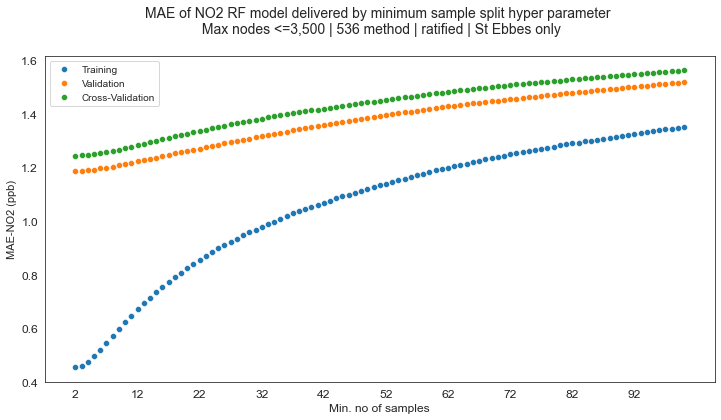

In [19]:
# Plot training & X validation results
#-------------------------------------
test=pd.DataFrame(scores)
plt.figure(figsize=(12,6))
sns.set_style("white", {'axes.grid' : False})

plt.rcParams['ytick.labelsize'] = '12'
plt.rcParams['xtick.labelsize'] = '12'

sns.scatterplot(x=test.columns,y=test.iloc[1], label='Training')
sns.scatterplot(x=test.columns,y=test.iloc[0], label='Validation')
sns.scatterplot(x=test.columns,y=test.iloc[2], label='Cross-Validation')

plt.ylabel('MAE-NO2 (ppb)',fontsize=11)
plt.xlabel('Min. no of samples',fontsize=12)
plt.title('MAE of NO2 RF model delivered by minimum sample split hyper parameter \n \
Max nodes <=3,500 | 536 method | ratified | St Ebbes only\n', fontsize=14)
plt.xticks(np.arange(min(test), max(test)+1, 10.0))
#plt.xticks(np.arange(min(test.columns), max(test.columns)+1, 1.0))

# Save figure if needed
#plt.savefig(pngs+'training_results_no2_mln5000_e100_sebbes_536_ratified.png', dpi=300)
plt.show()


In [20]:
n_estimators = [3500]
max_depth = [50,100,300]
min_samples_split = [2, 5, 10, 20, 40, 100]
min_samples_leaf = [1, 2, 5, 10] 

gsmodel = RandomForestRegressor(random_state=1, n_jobs=-1)

hyperF = dict(n_estimators = n_estimators, max_depth = max_depth,  
              min_samples_split = min_samples_split, 
             min_samples_leaf = min_samples_leaf)

gridF = GridSearchCV(gsmodel, hyperF, cv = 5, verbose = 2, scoring='neg_mean_absolute_error',
                      n_jobs = -1)
bestF = gridF.fit(train_X, train_y)

Fitting 5 folds for each of 72 candidates, totalling 360 fits
[CV] END max_depth=50, min_samples_leaf=1, min_samples_split=2, n_estimators=3500; total time=12.2min


/home/tonyb/miniconda3/envs/qoax/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END max_depth=50, min_samples_leaf=1, min_samples_split=2, n_estimators=3500; total time=12.4min
[CV] END max_depth=50, min_samples_leaf=1, min_samples_split=2, n_estimators=3500; total time=12.6min
[CV] END max_depth=50, min_samples_leaf=1, min_samples_split=2, n_estimators=3500; total time=13.0min
[CV] END max_depth=50, min_samples_leaf=1, min_samples_split=2, n_estimators=3500; total time=12.8min
[CV] END max_depth=50, min_samples_leaf=2, min_samples_split=2, n_estimators=3500; total time=10.8min
[CV] END max_depth=50, min_samples_leaf=1, min_samples_split=10, n_estimators=3500; total time=11.2min
[CV] END max_depth=50, min_samples_leaf=1, min_samples_split=20, n_estimators=3500; total time=10.7min
[CV] END max_depth=50, min_samples_leaf=2, min_samples_split=10, n_estimators=3500; total time=10.7min
[CV] END max_depth=50, min_samples_leaf=1, min_samples_split=10, n_estimators=3500; total time=11.8min
[CV] END max_depth=50, min_samples_leaf=1, min_samples_split=40, n_estimators=

In [21]:
gridF

GridSearchCV(cv=5, estimator=RandomForestRegressor(n_jobs=-1, random_state=1),
             n_jobs=-1,
             param_grid={'max_depth': [50, 100, 300],
                         'min_samples_leaf': [1, 2, 5, 10],
                         'min_samples_split': [2, 5, 10, 20, 40, 100],
                         'n_estimators': [3500]},
             scoring='neg_mean_absolute_error', verbose=2)

In [26]:
print(bestF.best_params_)
#allscores=bestF.cv_results_['mean_test_score']
print(bestF.cv_results_['mean_test_score'])
print(bestF.cv_results_['params'])

{'max_depth': 50, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 3500}
[-1.23318057 -1.239772   -1.26405782 -1.31992862 -1.40884614 -1.56041811
 -1.23431582 -1.23720473 -1.26128538 -1.31738088 -1.40721775 -1.55997154
 -1.27651795 -1.27651795 -1.27651795 -1.32669954 -1.41288608 -1.56230173
 -1.35554877 -1.35554877 -1.35554877 -1.35554877 -1.42867062 -1.56857962
 -1.23318057 -1.239772   -1.26405782 -1.31992862 -1.40884614 -1.56041811
 -1.23431582 -1.23720473 -1.26128538 -1.31738088 -1.40721775 -1.55997154
 -1.27651795 -1.27651795 -1.27651795 -1.32669954 -1.41288608 -1.56230173
 -1.35554877 -1.35554877 -1.35554877 -1.35554877 -1.42867062 -1.56857962
 -1.23318057 -1.239772   -1.26405782 -1.31992862 -1.40884614 -1.56041811
 -1.23431582 -1.23720473 -1.26128538 -1.31738088 -1.40721775 -1.55997154
 -1.27651795 -1.27651795 -1.27651795 -1.32669954 -1.41288608 -1.56230173
 -1.35554877 -1.35554877 -1.35554877 -1.35554877 -1.42867062 -1.56857962]
[{'max_depth': 50, 'min_samples_leaf

In [11]:
# Redefine the model using best tree size & number
#--------------------------------------------------
model = RandomForestRegressor(max_leaf_nodes=3500,
                              random_state=1,
                              n_estimators=100,
                              n_jobs=-1)

# fit the model
model.fit(train_X, train_y)
model_prediction = model.predict(val_X)


# Validation results

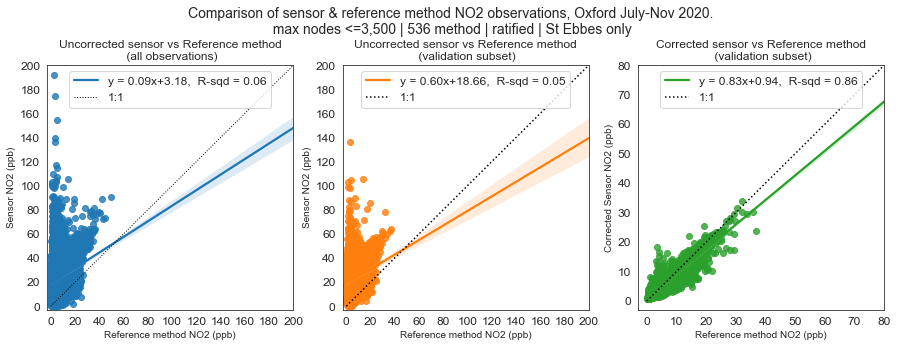

In [15]:
# Plot storyboard of model validation
#-------------------------------------

sns.set_style("white", {'axes.grid': False})

fig, axes = plt.subplots(1, 3, figsize=(15, 4.5))
fig.suptitle('Comparison of sensor & reference method NO2 observations, Oxford July-Nov 2020. \n \
max nodes <=3,500 | 536 method | ratified | St Ebbes only \n'                           , \
             y=1.06, \
             fontsize=14)

plt.rcParams['ytick.labelsize'] = '12'
plt.rcParams['xtick.labelsize'] = '12'
plt.rcParams['figure.titlesize'] = '12'

xlim = [0, 200]
axes[0].set_xlim(xlim)

# Get regression stats - sensor vs reference method
slope, intercept, r_value, p_value, std_err = stats.linregress(
    train_df['val.no2.cnc_1_c1'], train_df['no2_ppb_s'])
# Plot it
sns.regplot(x=train_df['no2_ppb_s'],
            y=train_df['val.no2.cnc_1_c1'],
            color='tab:blue',
            line_kws={
                'label':
                "y = {0:.2f}x+{1:.2f},  R-sqd = {3:.2f}".format(
                    slope, intercept, r_value, r_value**2)
            },
            ax=axes[0],
            truncate=False)
axes[0].set(xlabel='Reference method NO2 (ppb)',\
            ylabel='Sensor NO2 (ppb)',\
            title='Uncorrected sensor vs Reference method\n (all observations)',
            xlim=(-3,200),
            ylim=(-3,200),
            xticks=(np.arange(0,220,20)),
            yticks=(np.arange(0,220,20)))

one = [0, 100, 200]
sns.regplot(x=one,
            y=one,
            color='k',
            line_kws={
                'label': '1:1',
                'ls': ':',
                'lw': 1
            },
            scatter_kws={'s': 0},
            ax=axes[0],ci=None)

axes[1].set_xlim(xlim)

# Recalc regression stats - uncorrected validation subset sensor vs reference method
slope, intercept, r_value, p_value, std_err = stats.linregress(
    val_y, val_X['val.no2.cnc_1_c1'])
# Plot it
sns.regplot(x=val_y,
            y=val_X['val.no2.cnc_1_c1'],
            color='tab:orange',
            line_kws={
                'label':
                "y = {0:.2f}x+{1:.2f},  R-sqd = {3:.2f}".format(
                    slope, intercept, r_value, r_value**2)
            },
            ax=axes[1],
            truncate=False)
axes[1].set(
    xlabel='Reference method NO2 (ppb)',
    ylabel='Sensor NO2 (ppb)',
    title='Uncorrected sensor vs Reference method\n (validation subset)',
    xlim=(-3, 200),
    ylim=(-3, 200),
    xticks=(np.arange(0, 220, 20)),
    yticks=(np.arange(0, 220, 20)))

sns.regplot(x=one,
            y=one,
            color='k',
            line_kws={
                'label': '1:1',
                'ls': ':',
                'lw': 1.5
            },
            scatter_kws={'s': 0},
            ax=axes[1],ci=None)

axes[2].set_xlim(0, 100)

# Recalc regression stats - corrected validation subset sensor vs reference method
slope, intercept, r_value, p_value, std_err = stats.linregress(
    val_y, model_prediction)
sns.regplot(x=val_y,
            y=model_prediction,
            color='tab:green',
            line_kws={
                'label':
                "y = {0:.2f}x+{1:.2f},  R-sqd = {3:.2f}".format(
                    slope, intercept, r_value, r_value**2)
            },
            ax=axes[2],
            truncate=False)
axes[2].set(xlabel='Reference method NO2 (ppb)',
            ylabel='Corrected Sensor NO2 (ppb)',
            title='Corrected sensor vs Reference method\n (validation subset)',
            xlim=(-3, 80),
            ylim=(-3, 80),
            xticks=(np.arange(0, 85, 10)),
            yticks=(np.arange(0, 85, 10)))

one = [0, 100, 200]
sns.regplot(x=one,
            y=one,
            color='k',
            line_kws={
                'label': '1:1',
                'ls': ':',
                'lw': 1.5
            },
            scatter_kws={'s': 0},
            ax=axes[2],ci=None)

axes[0].legend(loc="upper center", fontsize=12)
axes[1].legend(loc="upper center", fontsize=12)
axes[2].legend(loc="upper center", fontsize=12)

##Save figure if needed.
fig.savefig(pngs + 'training_results_no2_mln3500_e100_sebbes_356_ratified.png',
            dpi=300)


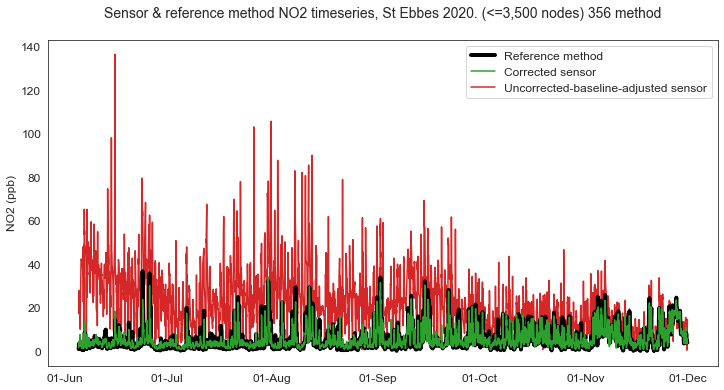

In [14]:
# Create a time series before & after, Jun to Nov
#------------------------------------------------
myFmt = mdates.DateFormatter('%d-%b')

#sns.set_style("white", {'axes.grid' : False})

plt.rcParams['ytick.labelsize'] = '12'
plt.rcParams['xtick.labelsize'] = '12'
plt.rcParams['figure.titlesize'] = '12'

# Model prediction
model_prediction = model.predict(val_X)

#Plot results
fig = plt.figure(figsize=(12, 6))
fig.add_subplot(111)
ax1 = sns.lineplot(x=list(val_y.index),
                   y=val_y,
                   label='Reference method',
                   color='k',
                   lw=4, zorder=2)
ax1 = sns.lineplot(x=list(val_y.index),
                   y=model_prediction,
                   label='Corrected sensor',
                   color='tab:green', zorder=3)
ax1 = sns.lineplot(x=list(val_y.index),
                   y=list(val_X['val.no2.cnc_1_c1']),
                   label='Uncorrected-baseline-adjusted sensor',
                   color='tab:red', zorder=1)
ax1.xaxis.set_major_locator(MonthLocator())
ax1.xaxis.set_major_formatter(myFmt)
#plt.ylim((-5, 80))
ax1.set_title('Sensor & reference method NO2 timeseries, St Ebbes 2020. (<=3,500 nodes) 356 method\n', fontsize=14)

plt.ylabel('NO2 (ppb)', fontsize=12)
plt.xlabel('')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
ax1.legend(loc='upper right',fontsize=12)

plt.savefig(pngs + 'validation_results_no2_mln3500_e100_sebbes1_356_ratified.png', dpi=300)
plt.show()

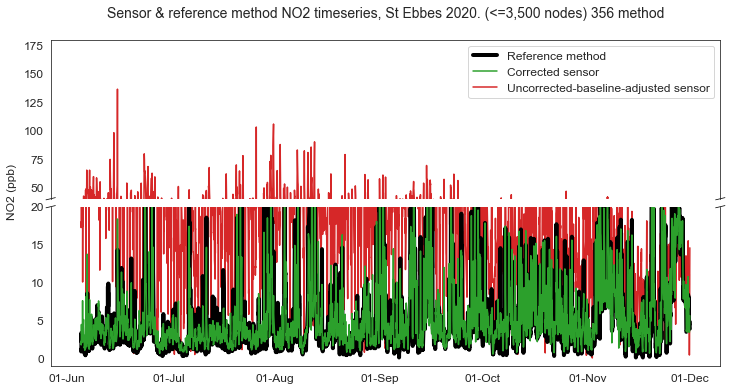

In [16]:
# Plotting the verification results using December 2020 data - split
#--------------------------------------------------------------------
sns.set_style("white", {'axes.grid': False})

myFmt = mdates.DateFormatter('%d-%b')

plt.rcParams['ytick.labelsize'] = '12'
plt.rcParams['xtick.labelsize'] = '12'
plt.rcParams['figure.titlesize'] = '12'


f, (ax, ax2) = plt.subplots(2, 1, sharex=True, figsize=(12, 6))

sns.lineplot(x=list(val_y.index),
             y=val_y,
             label='Reference method',
             color='k',
             lw=4,
             zorder=2,
             ax=ax)
sns.lineplot(x=list(val_y.index),
             y=model_prediction,
             label='Corrected sensor',
             color='tab:green',
             zorder=3,
             ax=ax)
sns.lineplot(x=list(val_y.index),
             y=list(val_X['val.no2.cnc_1_c1']),
             label='Uncorrected-baseline-adjusted sensor',
             color='tab:red',
             zorder=1,
             ax=ax)

sns.lineplot(x=list(val_y.index), y=val_y, color='k', lw=4, zorder=2, ax=ax2)
sns.lineplot(x=list(val_y.index),
             y=model_prediction,
             color='tab:green',
             zorder=3,
             ax=ax2)
sns.lineplot(x=list(val_y.index),
             y=list(val_X['val.no2.cnc_1_c1']),
             color='tab:red',
             zorder=1,
             ax=ax2)

# zoom-in / limit the view to different portions of the data
ax.set_ylim(40, 180)  # outliers only
ax2.set_ylim(-1, 20)  # most of the data
ax.set_yticks=(np.arange(0,25,10))

# hide the spines between ax and ax2
ax.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax.xaxis.set_ticks_position('none')
ax2.yaxis.set_label_coords(-0.05, 1.1)
ax.yaxis.label.set_visible(False)

d = .007  # how big to make the diagonal lines in axes coordinates
# arguments to pass to plot, just so we don't keep repeating them
kwargs = dict(transform=ax.transAxes, color='k', clip_on=False, lw=0.75)
ax.plot((-d, +d), (-d, +d), **kwargs)  # top-left diagonal
ax.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal
ax2.xaxis.set_major_formatter(myFmt)
kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal


# What's cool about this is that now if we vary the distance between
# ax and ax2 via f.subplots_adjust(hspace=...) or plt.subplot_tool(),
# the diagonal lines will move accordingly, and stay right at the tips
# of the spines they are 'breaking'

f.subplots_adjust(hspace=0.05)

plt.ylabel('NO2 (ppb)',fontsize=12)
ax.legend(loc='upper right',fontsize=12)
ax.set_title('Sensor & reference method NO2 timeseries, St Ebbes 2020. (<=3,500 nodes) 356 method\n',
             fontsize=14)

plt.savefig(pngs + 'validation_results_no2_mln3500_e100_sebbes_356_ratified_split.png',
            dpi=300)
plt.show()

# Parameter importance

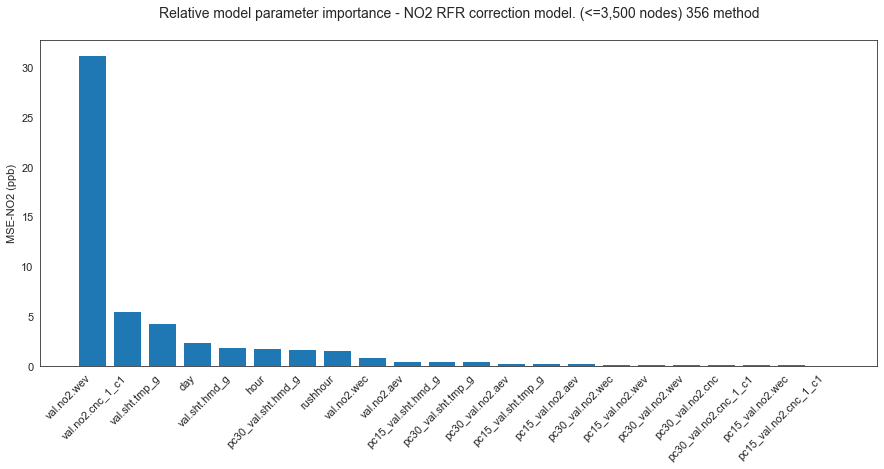

In [17]:
# Permutation importance is a method for determining how important a parameter is by sequentially 
#shuffling model parameters and measuring the effect on model accuracy (MAE in this case) 

# perform permutation importance
results = permutation_importance(model,train_X, train_y, scoring='neg_mean_squared_error')

# get importance
importance = results.importances_mean
importance=pd.DataFrame(importance,index=train_X.columns, columns=['MSE'])
importance=importance.sort_values(by='MSE',ascending=False)

sns.set_style("white", {'axes.grid' : False})

fig = plt.figure(figsize=(15,6))
ax1 = fig.add_subplot(111)
plt.bar(importance.index,importance.MSE);
plt.ylabel('MSE-NO2 (ppb)', fontsize=11)
ax1.xaxis.set_tick_params(rotation=45)
plt.setp(ax1.xaxis.get_majorticklabels(), ha='right', fontsize=12)
plt.title('Relative model parameter importance - NO2 RFR correction model. (<=3,500 nodes) 356 method\n', fontsize=14)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)

#Save figure if needed
plt.savefig(pngs+'parameter_importance_no2_mln3500_e100_sebbes_356_ratified.png', dpi=300)



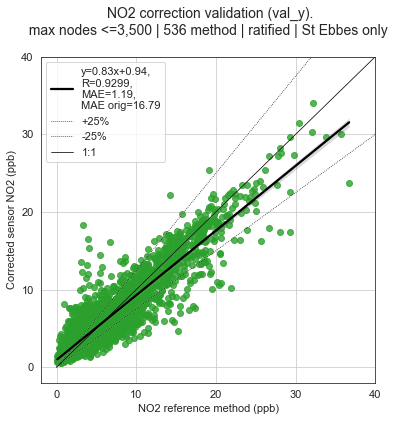

<Figure size 432x288 with 0 Axes>

In [19]:
# Plot regression analysis of corrected verification sensor obs vs AURN
#-----------------------------------------------------------------------
sns.set_style("white", {'axes.grid': True})

one = [0, 20, 40, 60, 80, 100]
upper = [i * 1.250 for i in one]
lower = [i * 0.750 for i in one]

slope, intercept, r_value, p_value, std_err = stats.linregress(
    val_y, model_prediction)
mae_veri = mean_absolute_error(val_y, model_prediction)
mae_orig = mean_absolute_error(val_y, val_X['val.no2.cnc_1_c1'])

fig = plt.figure(1, figsize=(6, 6))
fig.add_subplot(111)
ax1 = sns.regplot(
    x=val_y,
    y=model_prediction,
    color='tab:green',
    line_kws={
        'label':
        'y={0:.2f}x+{1:.2f},\nR={2:.4f},\nMAE={3:.2f},\nMAE orig={4:.2f}'.
        format(slope, intercept, r_value, mae_veri, mae_orig),
        'color':
        'k'
    })
ax2 = sns.regplot(x=one,
                  y=upper,
                  color='k',
                  line_kws={
                      'label': '+25%',
                      'ls': ':',
                      'lw': 0.75
                  },
                  scatter_kws={'s': 0})

ax3 = sns.regplot(x=one,
                  y=lower,
                  color='k',
                  line_kws={
                      'label': '-25%',
                      'ls': ':',
                      'lw': 0.75
                  },
                  scatter_kws={'s': 0})

ax4 = sns.regplot(x=one,
                  y=one,
                  color='k',
                  line_kws={
                      'label': '1:1',
                      'ls': '-',
                      'lw': 0.75
                  },
                  scatter_kws={'s': 0})

ax1.set_xlim(-2, 40)
ax1.set_ylim(-2, 40)
ax1.set_xticks(np.arange(0, 45, 10))
ax1.set_yticks(np.arange(0, 45, 10))
plt.legend(fontsize=11)
plt.ylabel('Corrected sensor NO2 (ppb)', fontsize=11)
plt.xlabel('NO2 reference method (ppb)', fontsize=11)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
ax1.set_title(' NO2 correction validation (val_y).\n \
max nodes <=3,500 | 536 method | ratified | St Ebbes only \n', fontsize=14)
plt.show()

# Save figure if needed
plt.savefig(pngs + 'verification_regression_no2_mln3500_e100_sebbes_356_ratified.png',
            dpi=300)

## Save model

In [20]:
# Save the model to disk
#------------------------
filename = folder+'RFR_model_no2_mln3500_e100_sebbes_356_ratified.sav'
pickle.dump(model, open(filename, 'wb'))


In [21]:
# Read the saved model to avoid all the working above
#-----------------------------------------------------
model = pickle.load(open(folder+'RFR_model_no2_mln3500_e100_sebbes_356_ratified.sav', 'rb'))


In [22]:
# Save the interesting variables to a csv for CEN expanded uncertainty calcs
#----------------------------------------------------------------------------
import csv

outfile = list(
    zip(val_y.index, val_y.values, model_prediction))

with open('no2_values_for_cen_calculation_sebbes_3500_356_ratified.csv', 'w') as out:
    csv_out = csv.writer(out)
    csv_out.writerow(
        ['datetime', 'no2_ppb_s', 'val.no2.cnc_1_c2'])
    csv_out.writerows(outfile)
    

In [23]:
mae_veri = mean_absolute_error(val_y, model_prediction)
mae_orig = mean_absolute_error(val_y, val_X['val.no2.cnc_1_c1'])

print('MAE in uncorrected verifiction data for Jun to Nov: '+str(mae_orig))
print('MAE in corrected verifiction data for Jun to Nov: '+str(mae_veri))
print('% 0.1f' % mae_orig, '% 0.1f' % mae_veri)

MAE in uncorrected verifiction data for Jun to Nov: 16.793211
MAE in corrected verifiction data for Jun to Nov: 1.186598863537167
 16.8  1.2


In [24]:
# Constraining training to Jun to Nov, verification to Dec
# --------------------------------------------------------

jun = dt.datetime(2020, 6, 1, 0, 0, 0, tzinfo=pytz.utc)
dec = dt.datetime(2020, 12, 1, 0, 0, 0, tzinfo=pytz.utc)
jan = dt.datetime(2021, 1, 1, 0, 0, 0, tzinfo=pytz.utc)

df = sebbes_train_s15_1.reset_index('tag')
val_dec = df.query('@dec < index <= @jan')

# Get dec validation data
# -------------------------
validate_df = val_dec.loc[:, [
    'val.no2.wev',
    'val.no2.aev',
    'val.no2.wec',
    'val.sht.hmd_g',
    'val.sht.tmp_g',
    'no2_ppb_s',
    'no2_ppb_h',
    'val.no2.cnc_1_c1',
    'pc15_val.no2.wev',
    'pc15_val.no2.aev',
    'pc15_val.no2.wec',
    'pc15_val.sht.hmd_g',
    'pc15_val.sht.tmp_g',
    'pc15_val.no2.cnc_1_c1',
    'pc30_val.no2.wev',
    'pc30_val.no2.cnc',
    'pc30_val.no2.aev',
    'pc30_val.no2.wec',
    'pc30_val.sht.hmd_g',
    'pc30_val.sht.tmp_g',
    'pc30_val.no2.cnc_1_c1',
    'hour',
    'day',
    'rushhour'
]]

# Drop weirdness in some columns
validate_df = validate_df.replace([np.inf, -np.inf], np.nan).dropna(axis=0)
train_df = train_df.replace([np.inf, -np.inf], np.nan).dropna(axis=0)


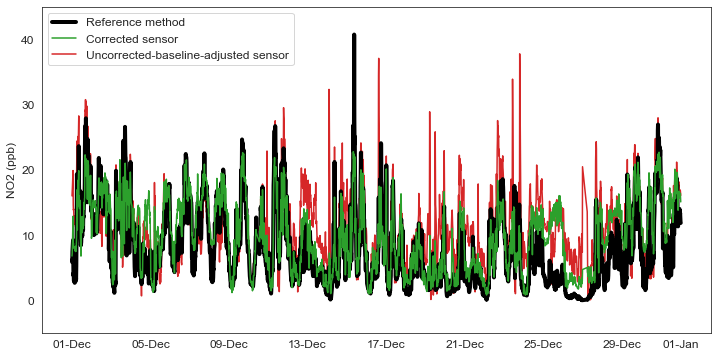

In [26]:
# Plotting the verification results using December 2020 data
#------------------------------------------------------------
myFmt = mdates.DateFormatter('%d-%b')

sns.set_style("white", {'axes.grid': False})

plt.rcParams['ytick.labelsize'] = '12'
plt.rcParams['xtick.labelsize'] = '12'
plt.rcParams['figure.titlesize'] = '12'

df0 = validate_df.loc[:,'no2_ppb_s']
df1 = validate_df.drop(columns=['no2_ppb_s', 'no2_ppb_h'])

# Model prediction
model_prediction = model.predict(df1)

# Plot results
fig = plt.figure(1, figsize=(12, 6))
fig.add_subplot(111)
ax1 = sns.lineplot(x=list(df0.index),
                   y=list(df0.values),
                   label='Reference method',
                   color='k',
                   lw=4,
                   zorder=2)
ax1 = sns.lineplot(x=df1.index,
                   y=model_prediction,
                   label='Corrected sensor',
                   color='tab:green',
                   zorder=3)
ax1 = sns.lineplot(x=df1.index,
                   y=df1['val.no2.cnc_1_c1'],
                   label='Uncorrected-baseline-adjusted sensor',
                   color='tab:red',
                   zorder=1)
#ax1.xaxis.set_major_locator()
ax1.xaxis.set_major_formatter(myFmt)
plt.ylim((-5, 45))
plt.ylabel('NO2 (ppb)', fontsize=12)
plt.xlabel('')

plt.legend(fontsize=12,loc='upper left')
plt.savefig(pngs + 'verification_results_no2_mln3500_sebbes_e100_356_ratified_dec.png', dpi=300)
plt.show()

In [27]:
# Save the interesting variables to a csv for CEN expanded uncertainty calcs
#----------------------------------------------------------------------------
import csv

outfile = list(
    zip(df0.index, df0.values, model_prediction))

with open('no2_values_for_cen_calculation_sebbes_3500_356_ratified_dec.csv', 'w') as out:
    csv_out = csv.writer(out)
    csv_out.writerow(
        ['datetime', 'no2_ppb_s', 'val.no2.cnc_1_c2'])
    csv_out.writerows(outfile)
    

mae_veri = mean_absolute_error(df0.values, model_prediction)
mae_orig = mean_absolute_error(df0.values, df1['val.no2.cnc_1_c1'])

print('MAE in uncorrected verifiction datafor December: '+str(mae_orig))
print('MAE in corrected verifiction data for December: '+str(mae_veri))
print('% 0.1f' % mae_orig,'% 0.1f' % mae_veri)


MAE in uncorrected verifiction datafor December: 4.1422477
MAE in corrected verifiction data for December: 2.62418608930717
 4.1  2.6


In [29]:
# Doing verification with Dec unseen data with extra uniform backround time slots
# ---------------------------------------------------------------------------------

# Sensor data for colocated device at St Ebbes
# ----------------------------------------------
sebbes_train_s15 = sebbes_train_s15.reset_index().set_index(
    ['tag', 'rec']).sort_index()
sebbes_train_s15_2021 = pd.read_feather(folder + 'q12021/sebbes_train_536_s15+2021.ftr').set_index(
    ['tag', 'rec']).sort_index()

# Convert all float64 cols to float32
cols = sebbes_train_s15_2021.select_dtypes(np.float64).columns
sebbes_train_s15_2021[cols] = sebbes_train_s15_2021[cols].astype(np.float32)

jun = dt.datetime(2020, 6, 1, 0, 0, 0, tzinfo=pytz.utc)
dec = dt.datetime(2020, 12, 1, 0, 0, 0, tzinfo=pytz.utc)
apr = dt.datetime(2021, 4, 1, 0, 0, 0, tzinfo=pytz.utc)

# Constraining sebbes verification to Dec 2020
# ---------------------------------------------

df = pd.concat([sebbes_train_s15, sebbes_train_s15_2021])  # .reset_index()

# add features
# --------------
tmp_list = []
for tag, dat in df.reset_index().groupby('tag'):
    tmpdf = no2_feature_gen(dat)
    tmpdf = rushhour(tmpdf)
    tmp_list.append(tmpdf)
df = pd.concat(tmp_list).sort_index()

val_dec_sebbes = df.query('@dec <= rec < @apr')

# Get dec validation data
# -------------------------
validate_df = val_dec_sebbes.loc[:, [
    'val.no2.wev',
    'val.no2.aev',
    'val.no2.wec',
    'val.sht.hmd_g',
    'val.sht.tmp_g',
    'no2_ppb_s',
    'no2_ppb_h',
    'val.no2.cnc_1_c1',
    'pc15_val.no2.wev',
    'pc15_val.no2.aev',
    'pc15_val.no2.wec',
    'pc15_val.sht.hmd_g',
    'pc15_val.sht.tmp_g',
    'pc15_val.no2.cnc_1_c1',
    'pc30_val.no2.wev',
    'pc30_val.no2.cnc',
    'pc30_val.no2.aev',
    'pc30_val.no2.wec',
    'pc30_val.sht.hmd_g',
    'pc30_val.sht.tmp_g',
    'pc30_val.no2.cnc_1_c1',
    'hour',
    'day',
    'rushhour'
]]

# Drop weirdness in some columns
validate_df = validate_df.replace([np.inf, -np.inf],
                                  np.nan).dropna(axis=0).sort_index()
validate_df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 49442 entries, ('scs-bgx-538', Timestamp('2020-12-01 00:00:00+0000', tz='UTC')) to ('scs-bgx-538', Timestamp('2021-03-31 23:45:00+0000', tz='UTC'))
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   val.no2.wev            49442 non-null  float32
 1   val.no2.aev            49442 non-null  float32
 2   val.no2.wec            49442 non-null  float32
 3   val.sht.hmd_g          49442 non-null  float32
 4   val.sht.tmp_g          49442 non-null  float32
 5   no2_ppb_s              49442 non-null  float32
 6   no2_ppb_h              49442 non-null  float32
 7   val.no2.cnc_1_c1       49442 non-null  float32
 8   pc15_val.no2.wev       49442 non-null  float32
 9   pc15_val.no2.aev       49442 non-null  float32
 10  pc15_val.no2.wec       49442 non-null  float32
 11  pc15_val.sht.hmd_g     49442 non-null  float32
 12  pc15_val.sht.tmp_g     49442 non-nul

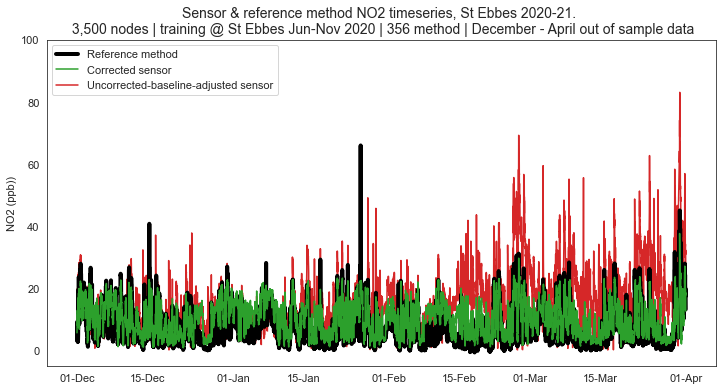

In [30]:
# Plotting the verification results using December 2020 data 
#------------------------------------------------------------
myFmt = mdates.DateFormatter('%d-%b')

sns.set_style("white", {'axes.grid': False})

df0 = validate_df.loc[:,'no2_ppb_s']
df1 = validate_df.drop(columns=['no2_ppb_s','no2_ppb_h'])

# Model prediction
model_prediction = model.predict(df1)

# Plot results
fig = plt.figure(1, figsize=(12, 6))
fig.add_subplot(111)
ax1 = sns.lineplot(x=df0.index.get_level_values(1),
                   y=df0.values,
                   label='Reference method',
                   color='k',
                   lw=4,
                   zorder=2)
ax1 = sns.lineplot(x=df1.index.get_level_values(1),
                   y=model_prediction,
                   label='Corrected sensor',
                   color='tab:green',
                   zorder=3)
ax1 = sns.lineplot(x=df1.index.get_level_values(1),
                   y=df1['val.no2.cnc_1_c1'],
                   label='Uncorrected-baseline-adjusted sensor',
                   color='tab:red',
                   zorder=1)
#ax1.xaxis.set_major_locator()
ax1.xaxis.set_major_formatter(myFmt)
plt.ylim((-5, 100))
plt.ylabel('NO2 (ppb))', fontsize=11)
plt.xlabel('')
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.legend(fontsize=11,loc='upper left')
ax1.set_title('Sensor & reference method NO2 timeseries, St Ebbes 2020-21. \n \
3,500 nodes | training @ St Ebbes Jun-Nov 2020 | 356 method | December - April out of sample data', fontsize=14)
plt.savefig(pngs + 'verification_results_no2_mln3500_sebbes_e100_converging_536_ratified_apr.png', dpi=300)
plt.show()

In [31]:
# Doing verification with High St Dec onward unseen data 
# -------------------------------------------------------

# Sensor data for colocated device at High St
# --------------------------------------------

highs_train_s15_2020 = pd.read_feather(folder + 'highs_train_536_s15_ratified.ftr').set_index(
    ['tag','rec']).sort_index()
highs_train_s15_2021 = pd.read_feather(folder + 'q12021/highs_train_536_s15+2021.ftr').set_index(
    ['tag', 'rec']).sort_index()

# Convert all float64 cols to float32
cols = highs_train_s15_2021.select_dtypes(np.float64).columns
highs_train_s15_2021[cols] = highs_train_s15_2021[cols].astype(np.float32)

jun = dt.datetime(2020, 6, 1, 0, 0, 0, tzinfo=pytz.utc)
dec = dt.datetime(2020, 12, 1, 0, 0, 0, tzinfo=pytz.utc)
apr = dt.datetime(2021, 4, 1, 0, 0, 0, tzinfo=pytz.utc)

# Constraining sebbes verification to Dec 2020
# ---------------------------------------------

df = pd.concat([highs_train_s15_2020, highs_train_s15_2021]).reset_index()


# add features
# --------------
tmp_list = []
for tag, dat in df.reset_index().groupby('tag'):
    tmpdf = no2_feature_gen(dat)
    tmpdf = rushhour(tmpdf)
    tmp_list.append(tmpdf)
df = pd.concat(tmp_list).sort_index()

val_highs = df.query('rec >= @dec & tag == "scs-bgx-536"').sort_index()

# Get dec validation data
# -------------------------
validate_df = val_highs.loc[:, [
    'val.no2.wev',
    'val.no2.aev',
    'val.no2.wec',
    'val.sht.hmd_g',
    'val.sht.tmp_g',
    'no2_ppb_s',
    'no2_ppb_h',
    'val.no2.cnc_1_c1',
    'pc15_val.no2.wev',
    'pc15_val.no2.aev',
    'pc15_val.no2.wec',
    'pc15_val.sht.hmd_g',
    'pc15_val.sht.tmp_g',
    'pc15_val.no2.cnc_1_c1',
    'pc30_val.no2.wev',
    'pc30_val.no2.cnc',
    'pc30_val.no2.aev',
    'pc30_val.no2.wec',
    'pc30_val.sht.hmd_g',
    'pc30_val.sht.tmp_g',
    'pc30_val.no2.cnc_1_c1',
    'hour',
    'day',
    'rushhour'
]]

# Drop weirdness in some columns
validate_df = validate_df.replace([np.inf, -np.inf],
                                  np.nan).dropna(axis=0).sort_index()
validate_df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 54221 entries, ('scs-bgx-536', Timestamp('2020-12-01 00:00:00+0000', tz='UTC')) to ('scs-bgx-536', Timestamp('2021-06-01 00:00:00+0000', tz='UTC'))
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   val.no2.wev            54221 non-null  float32
 1   val.no2.aev            54221 non-null  float32
 2   val.no2.wec            54221 non-null  float32
 3   val.sht.hmd_g          54221 non-null  float32
 4   val.sht.tmp_g          54221 non-null  float32
 5   no2_ppb_s              54221 non-null  float32
 6   no2_ppb_h              54221 non-null  float32
 7   val.no2.cnc_1_c1       54221 non-null  float64
 8   pc15_val.no2.wev       54221 non-null  float32
 9   pc15_val.no2.aev       54221 non-null  float32
 10  pc15_val.no2.wec       54221 non-null  float32
 11  pc15_val.sht.hmd_g     54221 non-null  float32
 12  pc15_val.sht.tmp_g     54221 non-nul

In [38]:
df0 = validate_df.loc[:,['no2_ppb_h','no2_ppb_s']]
df0

no2_ppb_h  no2_ppb_s
tag         rec                                            
scs-bgx-536 2020-12-01 00:00:00+00:00  12.990000       3.89
            2020-12-01 00:15:00+00:00  13.740000       6.14
            2020-12-01 00:30:00+00:00  10.230000       5.83
            2020-12-01 00:45:00+00:00  10.220000       7.47
            2020-12-01 01:30:00+00:00   9.930000       9.21
...                                          ...        ...
            2021-05-31 23:00:00+00:00  10.030000      17.01
            2021-05-31 23:15:00+00:00  12.330000      11.13
            2021-05-31 23:30:00+00:00  18.820000      10.82
            2021-05-31 23:45:00+00:00  16.190001      14.07
            2021-06-01 00:00:00+00:00  12.890000      14.80

[54221 rows x 2 columns]

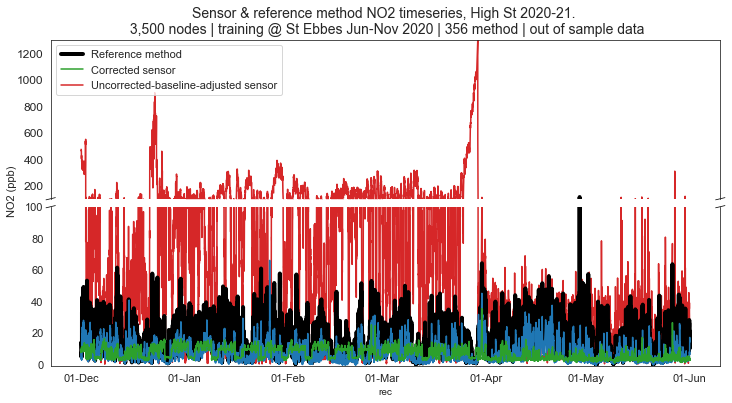

In [40]:
# Plotting the verification results using December 2020 data - split
#--------------------------------------------------------------------
myFmt = mdates.DateFormatter('%d-%b')

sns.set_style("white", {'axes.grid': False})

df0 = validate_df.loc[:,['no2_ppb_h','no2_ppb_s']]
df1 = validate_df.drop(columns=['no2_ppb_s','no2_ppb_h'])

# Model prediction
model_prediction = model.predict(df1)


plt.rcParams['ytick.labelsize'] = '12'
plt.rcParams['xtick.labelsize'] = '12'
plt.rcParams['figure.titlesize'] = '12'

f, (ax, ax2) = plt.subplots(2, 1, sharex=True, figsize=(12, 6))

sns.lineplot(x=df0.index.get_level_values(1),
             y=df0['no2_ppb_h'],
             label='Reference method',
             color='k',
             lw=4,
             zorder=2,
             ax=ax)
sns.lineplot(x=df1.index.get_level_values(1),
             y=model_prediction,
             label='Corrected sensor',
             color='tab:green',
             zorder=3,
             ax=ax)
sns.lineplot(x=df1.index.get_level_values(1),
             y=df1['val.no2.cnc_1_c1'],
             label='Uncorrected-baseline-adjusted sensor',
             color='tab:red',
             zorder=1,
             ax=ax)

sns.lineplot(x=df0.index.get_level_values(1),
             y=df0['no2_ppb_h'],
             color='k',
             lw=4,
             zorder=2,
             ax=ax2)
sns.lineplot(x=df1.index.get_level_values(1),
             y=model_prediction,
             color='tab:green',
             zorder=4,
             ax=ax2)
sns.lineplot(x=df1.index.get_level_values(1),
             y=df1['val.no2.cnc_1_c1'],
             color='tab:red',
             zorder=1,
             ax=ax2)
sns.lineplot(x=df1.index.get_level_values(1),
             y=df0['no2_ppb_s'],
             color='tab:blue',
             zorder=3,
             ax=ax2)

# zoom-in / limit the view to different portions of the data
ax.set_ylim(100, 1350)  # outliers only
ax2.set_ylim(-1, 100)  # most of the data
ax.set_yticks=(np.arange(0,30,20))

# hide the spines between ax and ax2
ax.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax.xaxis.set_ticks_position('none')
ax2.yaxis.set_label_coords(-0.05, 1.1)
ax.yaxis.label.set_visible(False)
ax2.xaxis.set_major_formatter(myFmt)


d = .007  # how big to make the diagonal lines in axes coordinates
# arguments to pass to plot, just so we don't keep repeating them
kwargs = dict(transform=ax.transAxes, color='k', clip_on=False, lw=0.75)
ax.plot((-d, +d), (-d, +d), **kwargs)  # top-left diagonal
ax.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal
#ax2.xaxis.set_major_formatter(myFmt)
kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal


# What's cool about this is that now if we vary the distance between
# ax and ax2 via f.subplots_adjust(hspace=...) or plt.subplot_tool(),
# the diagonal lines will move accordingly, and stay right at the tips
# of the spines they are 'breaking'

f.subplots_adjust(hspace=0.05)

plt.ylabel('NO2 (ppb)',fontsize=11)
ax.legend(loc='upper left',fontsize=11)
ax.set_title('Sensor & reference method NO2 timeseries, High St 2020-21. \n \
3,500 nodes | training @ St Ebbes Jun-Nov 2020 | 356 method | out of sample data', fontsize=14)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
#plt.savefig(pngs + 'validation_results_no2_mln5000_e100_split_converging_sebbes_highs_536_ratified.png',
#            dpi=300)
plt.show()


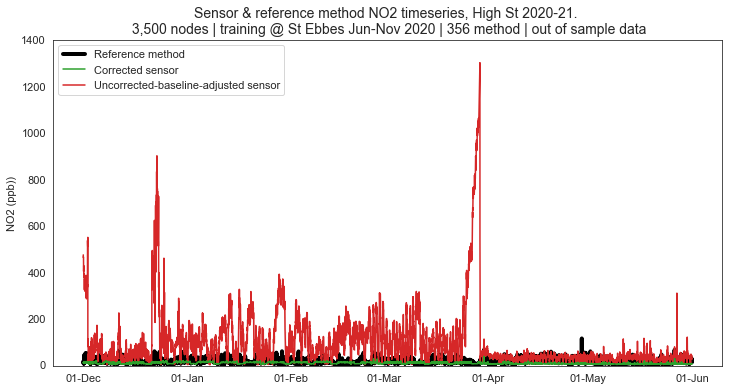

In [42]:
# Plotting the verification results using December 2020 data & with extra uniform backround time slots
#------------------------------------------------------------------------------------------------------
myFmt = mdates.DateFormatter('%d-%b')

sns.set_style("white", {'axes.grid': False})

df0 = validate_df.loc[:,'no2_ppb_h']
df1 = validate_df.drop(columns=['no2_ppb_s','no2_ppb_h'])

# Model prediction
model_prediction = model.predict(df1)

# Plot results
fig = plt.figure(1, figsize=(12, 6))
fig.add_subplot(111)
ax1 = sns.lineplot(x=df0.index.get_level_values(1),
                   y=df0.values,
                   label='Reference method',
                   color='k',
                   lw=4,
                   zorder=2)
ax1 = sns.lineplot(x=df1.index.get_level_values(1),
                   y=model_prediction,
                   label='Corrected sensor',
                   color='tab:green',
                   zorder=3)
ax1 = sns.lineplot(x=df1.index.get_level_values(1),
                   y=df1['val.no2.cnc_1_c1'],
                   label='Uncorrected-baseline-adjusted sensor',
                   color='tab:red',
                   zorder=2)
#ax1.xaxis.set_major_locator()
ax1.xaxis.set_major_formatter(myFmt)
plt.ylim(-5, 1400)
plt.ylabel('NO2 (ppb))', fontsize=11)
plt.xlabel('')
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.legend(fontsize=11,loc='upper left')
ax1.set_title('Sensor & reference method NO2 timeseries, High St 2020-21. \n \
3,500 nodes | training @ St Ebbes Jun-Nov 2020 | 356 method | out of sample data', fontsize=14)
#plt.savefig(pngs + 'verification_results_no2_mln3500_sebbes_e100_converging_536_ratified_apr.png', dpi=300)
plt.show()

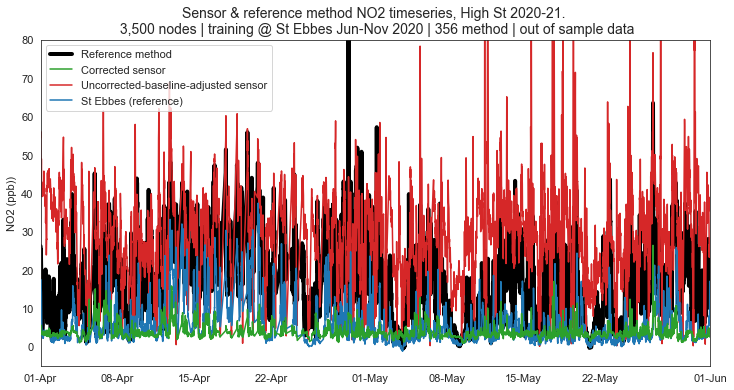

In [47]:
# Plotting the verification results using December 2020 data 
#------------------------------------------------------------
myFmt = mdates.DateFormatter('%d-%b')
apr21 = dt.datetime(2021, 4, 1, 0, 0, 0, tzinfo=pytz.utc)
jun21 = dt.datetime(2021, 6, 1, 0, 0, 0, tzinfo=pytz.utc)

sns.set_style("white", {'axes.grid': False})

df0 = validate_df.loc[:,['no2_ppb_h','no2_ppb_s']].query('@apr21 <= rec < @jun21')
df1 = validate_df.drop(columns=['no2_ppb_s','no2_ppb_h']).query('@apr21 <= rec < @jun21')

# Model prediction
model_prediction = model.predict(df1)

# Plot results
fig = plt.figure(1, figsize=(12, 6))
fig.add_subplot(111)
ax1 = sns.lineplot(x=df0.index.get_level_values(1),
                   y=df0['no2_ppb_h'],
                   label='Reference method',
                   color='k',
                   lw=4,
                   zorder=2)
ax1 = sns.lineplot(x=df1.index.get_level_values(1),
                   y=model_prediction,
                   label='Corrected sensor',
                   color='tab:green',
                   zorder=4)
ax1 = sns.lineplot(x=df1.index.get_level_values(1),
                   y=df1['val.no2.cnc_1_c1'],
                   label='Uncorrected-baseline-adjusted sensor',
                   color='tab:red',
                   zorder=2)
ax1 = sns.lineplot(x=df0.index.get_level_values(1),
                   y=df0['no2_ppb_s'],
                   label='St Ebbes (reference)',
                   color='tab:blue',
                   zorder=3)

ax1.xaxis.set_major_formatter(myFmt)
plt.ylim(-5, 80)
plt.ylabel('NO2 (ppb))', fontsize=11)
plt.xlabel('')
plt.xlim(apr21,jun21)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.legend(fontsize=11,loc='upper left')
ax1.set_title('Sensor & reference method NO2 timeseries, High St 2020-21. \n \
3,500 nodes | training @ St Ebbes Jun-Nov 2020 | 356 method | out of sample data', fontsize=14)
#plt.savefig(pngs + 'verification_results_no2_mln3500_sebbes_e100_converging_536_ratified_apr.png', dpi=300)
plt.show()